# BERT을 통한 딥러닝 분류 학습

사용 알고리즘:  BERT Fine-Tuning Tutorial with PyTorch
-> https://mccormickml.com/2019/07/22/BERT-fine-tuning

사용 데이터: Naver sentiment movie corpus v1.0
https://github.com/e9t/nsmc.git

* 본 내용은 https://github.com/deepseasw/bert-naver-movie-review 를 토대로 수정하였습니다. deepseasw님께 감사 드립니다.


## 환경 설정

In [1]:
#@title 환경설정

# Hugging Face의 트랜스포머 모델을 설치
!pip install transformers

import sys

from IPython.display import clear_output
clear_output(wait=True)

## 관련 라이브러스 설치
import tensorflow as tf

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

import keras
# from keras.preprocessing.sequence import pad_sequences  # path removed
from keras.utils import pad_sequences

from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import random
import time
import datetime

clear_output()

print('Python version : ', sys.version)
print('TensorFlow version : ', tf.__version__)
print('Keras version : ', keras.__version__)

Python version :  3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
TensorFlow version :  2.15.0
Keras version :  2.15.0


## 데이터 불러오기

In [3]:
#@title 데이터 불러오기 - 조중동/한경 기사 데이터
파일ID = '1Md8XHJADQWzO1mcl0ZnOm5ijp_cL8G4F'  #@param {type: "string"}
파일저장이름 = 'rawdata.tsv'  #@param {type: "string"}

!wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id={파일ID}' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id={파일ID}" -O {파일저장이름} && rm -rf ~/cookies.txt

print(파일저장이름+"을 정상적으로 가져왔습니다.")

# pandas import
import pandas as pd

# 파일을 DataFrame으로 전환
df = pd.read_csv(파일저장이름, sep='\t')
df = df.dropna(axis=0)
print(df)

'''
‘조선일보’, ‘중앙일보’, ‘동아일보’와 ‘한겨레’, ‘경향신문’ 각각에 대해
2022년 5월 10일부터 2023년 5월 23일까지 보도된 정치 기사만 수집한 데이터,
실습에 활용할 수 있도록 미리 하나의 csv 파일로 병합해 두었다.
'''

--2024-01-13 07:21:26--  https://docs.google.com/uc?export=download&confirm=&id=1Md8XHJADQWzO1mcl0ZnOm5ijp_cL8G4F
Resolving docs.google.com (docs.google.com)... 108.177.96.101, 108.177.96.113, 108.177.96.139, ...
Connecting to docs.google.com (docs.google.com)|108.177.96.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1Md8XHJADQWzO1mcl0ZnOm5ijp_cL8G4F&export=download [following]
--2024-01-13 07:21:26--  https://drive.usercontent.google.com/download?id=1Md8XHJADQWzO1mcl0ZnOm5ijp_cL8G4F&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.31.132, 2a00:1450:4013:c1a::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.31.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7737408 (7.4M) [application/octet-stream]
Saving to: ‘rawdata.tsv’

rawdata.tsv         100%[===================>]   7.38M  --.-KB/

'\n‘조선일보’, ‘중앙일보’, ‘동아일보’와 ‘한겨레’, ‘경향신문’ 각각에 대해 \n2022년 5월 10일부터 2023년 5월 23일까지 보도된 정치 기사만 수집한 데이터, \n실습에 활용할 수 있도록 미리 하나의 csv 파일로 병합해 두었다.\n'

In [4]:
#@title 데이터 선택하기

데이터량 = "81253"  #@param ['100', '1000', '5000','10000', '50000', '81253']
데이터량 = int(데이터량)

df = df.iloc[:데이터량]
print(df)

print(df["label"].groupby([df["label"]]).count())

      label                                               text
0      경향신문             이낙연 “미국도 할 말 하는 동맹 원할 것 한국 정치 길 잃은 상태”
1      경향신문  윤재옥 “공직자윤리법, 국회의원만이라도 빠르게 가상자산 신고할 수 있도록 수정안 낼 것”
2      경향신문                     이정미 “노무현 정신 기준에서 정치권 스스로 돌아봐야”
3      경향신문                          민주당, 성추행 고소당한 부천시의원 조사 착수
4      경향신문                   민주당, 박민식 부적격 기류  인사청문보고서 채택 불발되나
...     ...                                                ...
81248  동아일보                            국정원장 김규현 내정 북미라인 외교-안보통
81249  동아일보                    한동훈 “국민 보시기 불편 송구하다” 자녀 의혹 첫 사과
81250  동아일보             윤석열 대통령, 공식 임기 시작 0시 용산벙커에서 합참 보고 첫 업무
81251  동아일보                                  [사설]윤석열 대통령에게 바란다
81252  동아일보                [사설]한동훈, 딸 재산 의혹 국민 눈높이에서 겸허하게 해명하라

[81253 rows x 2 columns]
label
경향신문    18534
동아일보    14910
조선일보    16401
중앙일보    20000
한겨레     11408
Name: label, dtype: int64


In [6]:
# 임베딩(embedding)

## 텍스트로 되어 있는 라벨을 숫자로 변환
df.loc[df.label=='조선일보', 'label']='0'
df.loc[df.label=='중앙일보', 'label']='0'
df.loc[df.label=='동아일보', 'label']='0'
df.loc[df.label=='한겨레', 'label']='1'
df.loc[df.label=='경향신문', 'label']='1'
# df.loc[df.label=='분류추가', 'label']='2'

## label 값을 숫자형(numeric)으로 전환
df['label'] = df['label'].apply(pd.to_numeric)

print(df)

       label                                               text
0          1             이낙연 “미국도 할 말 하는 동맹 원할 것 한국 정치 길 잃은 상태”
1          1  윤재옥 “공직자윤리법, 국회의원만이라도 빠르게 가상자산 신고할 수 있도록 수정안 낼 것”
2          1                     이정미 “노무현 정신 기준에서 정치권 스스로 돌아봐야”
3          1                          민주당, 성추행 고소당한 부천시의원 조사 착수
4          1                   민주당, 박민식 부적격 기류  인사청문보고서 채택 불발되나
...      ...                                                ...
81248      0                            국정원장 김규현 내정 북미라인 외교-안보통
81249      0                    한동훈 “국민 보시기 불편 송구하다” 자녀 의혹 첫 사과
81250      0             윤석열 대통령, 공식 임기 시작 0시 용산벙커에서 합참 보고 첫 업무
81251      0                                  [사설]윤석열 대통령에게 바란다
81252      0                [사설]한동훈, 딸 재산 의혹 국민 눈높이에서 겸허하게 해명하라

[81253 rows x 2 columns]


In [7]:
#@title 훈련 데이터 비율 선택하기

훈련데이터비율 = 0.9  #@param ['0.9', '0.8', '0.7', '0.6']

## 훈련데이터와 테스트데이터로 분리
train=df.sample(frac=훈련데이터비율,random_state=200)
test=df.drop(train.index)

# text 열에서 중복인 내용이 있다면 중복 제거
train.drop_duplicates(subset = ['text'], inplace=True)

# 'text' 열의 각 텍스트에 대해 정규 표현식을 사용하여 한글과 공백을 제외한 모든 문자를 제거합니다. 이렇게 하면 텍스트에서 한글과 공백만 남게 됩니다.
train['text'] = train['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

# 공백은 Null 값으로 변경
train['text'].replace('', np.nan, inplace=True)

# Null 값 제거
train = train.dropna(how='any')

print('전처리 후 훈련용 샘플의 개수 :',len(train))

test.drop_duplicates(subset = ['text'], inplace=True) # text 열에서 중복인 내용이 있다면 중복 제거
test['text'] = test['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test['text'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test = test.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test))

<ipython-input-7-7ebd871194a8>:10: FutureWarning: The default value of regex will change from True to False in a future version.
  train['text'] = train['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
<ipython-input-7-7ebd871194a8>:16: FutureWarning: The default value of regex will change from True to False in a future version.
  test['text'] = test['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행


전처리 후 훈련용 샘플의 개수 : 72782
전처리 후 테스트용 샘플의 개수 : 8117


## 데이터 전처리 with bert

In [8]:
#@title 학습 데이터 처리 - BERT형식으로 변환

# 리뷰 문장 추출
sentences = train['text']
print('')
print('##### 원본 데이터 #####')
print(sentences[:10])

# BERT의 입력 형식에 맞게 변환
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
print('')
print('##### Bert 형식으로 변환 #####')
print(sentences[:10])


# 라벨 추출
labels = train['label'].values

print('')
print('##### 라벨 추출 #####')
print(labels)


##### 원본 데이터 #####
55262          윤 취임 주년 날에도 전 정권 탓 잘못 바로잡아온 시간
5367              황운하 김기현 향해 윤 대통령의 꼬리 잘치는 푸들
67660    한동훈 돈봉투 수사가 정치 탄압 승부조작 수사하면 스포츠 탄압이냐
77751            고민정 전용기 민간인 안타 박민영 김영철 탄 사진은
61333         신재생에너지 뜯어본다는 감사원 작년 문제없다 결론 바꿀까
35862         태영호 김재원 버티기에  징계수위 고민 최고회의 또 취소
12447       통일부 년 만에 감소 담대한 구상 북한인권 증진 힘싣기예산안
699        한 일 재무장관 회의도 가동 채비 통상 갈등 해소 물꼬 트이나
74905           검찰 두려워 할 사람은 범죄자뿐 한동훈 어록집 나온다
55892       송영길 있어야 할 곳 프랑스 아닌 국민 앞 민주당 귀국 촉구
Name: text, dtype: object

##### Bert 형식으로 변환 #####
['[CLS] 윤 취임 주년 날에도 전 정권 탓 잘못 바로잡아온 시간 [SEP]', '[CLS] 황운하 김기현 향해 윤 대통령의 꼬리 잘치는 푸들 [SEP]', '[CLS] 한동훈 돈봉투 수사가 정치 탄압 승부조작 수사하면 스포츠 탄압이냐 [SEP]', '[CLS] 고민정 전용기 민간인 안타 박민영 김영철 탄 사진은 [SEP]', '[CLS] 신재생에너지 뜯어본다는 감사원 작년 문제없다 결론 바꿀까 [SEP]', '[CLS] 태영호 김재원 버티기에  징계수위 고민 최고회의 또 취소 [SEP]', '[CLS] 통일부 년 만에 감소 담대한 구상 북한인권 증진 힘싣기예산안 [SEP]', '[CLS] 한 일 재무장관 회의도 가동 채비 통상 갈등 해소 물꼬 트이나 [SEP]', '[CLS] 검찰 두려워 할 사람은 범죄자뿐 한동훈 어록집 나온다 [SEP]', '[CLS] 송영길 있어야 할 곳 프랑스 아닌 국민 앞 민주당 귀국 촉구 [SE

![대체 텍스트](https://mino-park7.github.io/images/2019/02/bert-input-representation.png)

BERT의 입력은 위의 그림과 같은 형식입니다. Classification을 뜻하는 [CLS] 심볼이 제일 앞에 삽입됩니다. 파인튜닝시 출력에서 이 위치의 값을 사용하여 분류를 합니다. [SEP]은 Separation을 가리키는데, 두 문장을 구분하는 역할을 합니다. 이 예제에서는 문장이 하나이므로 [SEP]도 하나만 넣습니다.
<br>
<br>

In [9]:
#@title 학습 데이터 처리 - BERT로 토큰화하기

bert모델 = "bert-base-multilingual-cased"  #@param ['bert-base-multilingual-cased', 'bert-large-cased', 'bert-base-chinese']

#"bert-base-uncased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json",
#"bert-large-uncased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-config.json",
#"bert-base-cased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json",
#"bert-large-cased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-config.json",
#"bert-base-multilingual-uncased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased-config.json",
#"bert-base-multilingual-cased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-config.json",
#"bert-base-chinese": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-chinese-config.json",
#"bert-base-german-cased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-german-cased-config.json",
#"bert-large-uncased-whole-word-masking": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-whole-word-masking-config.json",
#"bert-large-cased-whole-word-masking": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-whole-word-masking-config.json",
#"bert-large-uncased-whole-word-masking-finetuned-squad": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-whole-word-masking-finetuned-squad-config.json",
#"bert-large-cased-whole-word-masking-finetuned-squad": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-whole-word-masking-finetuned-squad-config.json",
#"bert-base-cased-finetuned-mrpc": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-finetuned-mrpc-config.json",
#"bert-base-german-dbmdz-cased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-german-dbmdz-cased-config.json",
#"bert-base-german-dbmdz-uncased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-german-dbmdz-uncased-config.json",
#"bert-base-japanese": "https://s3.amazonaws.com/models.huggingface.co/bert/cl-tohoku/bert-base-japanese-config.json",
#"bert-base-japanese-whole-word-masking": "https://s3.amazonaws.com/models.huggingface.co/bert/cl-tohoku/bert-base-japanese-whole-word-masking-config.json",
#"bert-base-japanese-char": "https://s3.amazonaws.com/models.huggingface.co/bert/cl-tohoku/bert-base-japanese-char-config.json",
#"bert-base-japanese-char-whole-word-masking": "https://s3.amazonaws.com/models.huggingface.co/bert/cl-tohoku/bert-base-japanese-char-whole-word-masking-config.json",
#"bert-base-finnish-cased-v1": "https://s3.amazonaws.com/models.huggingface.co/bert/TurkuNLP/bert-base-finnish-cased-v1/config.json",
#"bert-base-finnish-uncased-v1": "https://s3.amazonaws.com/models.huggingface.co/bert/TurkuNLP/bert-base-finnish-uncased-v1/config.json",


# BERT의 토크나이저로 문장을 토큰으로 분리
tokenizer = BertTokenizer.from_pretrained(bert모델, do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

print (sentences[0])
print (tokenized_texts[0])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

[CLS] 윤 취임 주년 날에도 전 정권 탓 잘못 바로잡아온 시간 [SEP]
['[CLS]', '윤', '취임', '주', '##년', '날', '##에도', '전', '정', '##권', '탓', '잘', '##못', '바로', '##잡', '##아', '##온', '시', '##간', '[SEP]']


BERT는 형태소분석으로 토큰을 분리하지 않습니다. WordPiece라는 통계적인 방식을 사용합니다. 한 단어내에서 자주 나오는 글자들을 붙여서 하나의 토큰으로 만듭니다. 이렇게 하면 언어에 상관없이 토큰을 생성할 수 있다는 장점이 있습니다. 또한 신조어 같이 사전에 없는 단어를 처리하기도 좋습니다.

위의 결과에서 ## 기호는 앞 토큰과 이어진다는 표시입니다. 토크나이저는 여러 언어의 데이터를 기반으로 만든 'bert-base-multilingual-cased'를 사용합니다. 그래서 한글도 처리가 가능합니다.
<br>
<br>

문장의 최대 길이 : 105
문장의 평균 길이 : 41.2623588249842


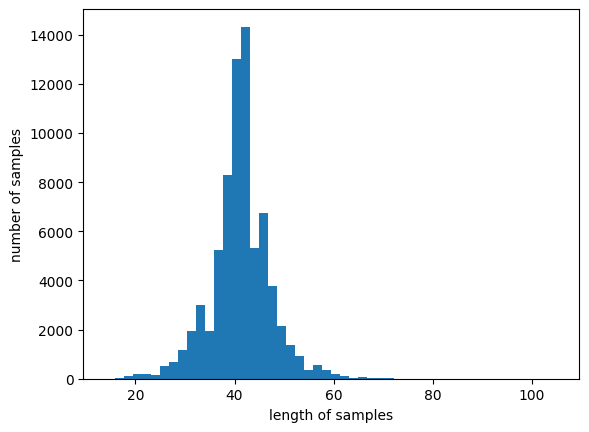

전체 샘플 중 길이가 64 이하인 샘플의 비율: 99.78978318815092


In [10]:
#@title 전처리를 위한 문장 길이 조회

## 전처리를 위한 기본 텍스트 정보를 탐색합니다.

최대길이 = "64"  #@param ['32', '64', '128', '256']
최대길이 = int(최대길이)

print('문장의 최대 길이 :',max(len(l) for l in sentences))
## 문장의 최대 길이는 가장 긴 문장의 길이를 의미합니다.

print('문장의 평균 길이 :',sum(map(len, sentences))/len(sentences))
## 문장의 평균 길이는 문장 길이의 평균값을 의미합니다.

import matplotlib.pyplot as plt

plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

## 문장 길이 전체 그래프를 살펴보면, 문장의 전체 분포를 볼 수 있습니다.
## 대다수의 문장이 50자 이하인 것을 알 수 있습니다.


def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))


max_len = 최대길이
below_threshold_len(max_len, sentences)

## max_leb(문장 최대 길이)가 128일때 선택되는 전체 데이터량을 의미합니다.
## 현재값은 95.92로 대략 6%를 제외한 모든 데이터가 선택된 것을 확인할 수 있습니다.

In [11]:
#@title 토큰 인덱스 변환, 패딩 및 어텐션 마스크 세팅

# 입력 토큰의 최대 시퀀스 길이
MAX_LEN = 최대길이

## 입력 문장의 최대 길이를 지정해줍니다.
## 물론 어떤 리뷰는 128자 이상이기도 합니다. 하지만 효율성을 위해서 고정해줍니다.
## MAX_LEN을 256, 512 등 더 크게 변경할 수도 있습니다. 그러면 처리 시간이 더 걸립니다. 대신 정확도는 상승합니다.
## 반대로 MAX_LEN을 64, 32 등 더 작게 변경할 수도 있습니다. 그러면 처리 시간은 짦아지고, 정확도는 줄어듭니다.
## MAX_LEN에 "정답"은 없습니다. 적절한 길이를 선택해야 합니다.

# 토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
## 패딩이란 MAX_LEN보다 짦은 문장에 적용합니다. 문장 길이가 120이라면 8개가 패딩으로 채워지게 됩니다.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

print(input_ids[0])

# 어텐션 마스크 초기화
attention_masks = []

# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print(attention_masks[0])

[   101   9627  71963   9689  10954   8985  35979   9665   9670  25347
   9851   9654 118940  71433 119199  16985  37093   9485  18784    102
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [12]:
#@title 훈련데이터와 검증 데이터 분리 및 배치 세팅

검증데이터비율 = "0.2"  #@param ['0.1', '0.2', '0.3']

배치크기 = "64"  #@param ['8', '16', '32', '64', '128', '256']
배치크기 = int(배치크기)


# 훈련셋과 검증셋으로 분리
validation_size = 검증데이터비율
## 훈련셋과 검증셋은 9:1로 분리해줍니다. 숫자를 변경하면 비율을 변경할 수 있습니다.

random_state = 1
## 컴퓨터에서의 분리는 시간값을 토대로 하는 랜덤입니다.
## 하지만 완전히 랜덤으로 하면 학습마다 다른 결과가 나오는 문제가 발생합니다.
## 이를 통제하기 위해서 랜덤 시작값을 세팅해줍니다.

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids,
                                                                                    labels,
                                                                                    random_state=random_state,
                                                                                    test_size=0.1)

# 어텐션 마스크를 훈련셋과 검증셋으로 분리
train_masks, validation_masks, _, _ = train_test_split(attention_masks,
                                                       input_ids,
                                                       random_state=random_state,
                                                       test_size=0.1)

# 데이터를 파이토치의 텐서로 변환
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

print("##### 훈련 텍스트의 bert embedding값 #####")
print(train_inputs[0])
print("##### 훈련 텍스트의 label 값 #####")
print(train_labels[0])
print("##### 훈련 텍스트의 MASK값 = 패딩 여부 확인 #####")
print(train_masks[0])
print("##### 검증 텍스트의 bert embedding값 #####")
print(validation_inputs[0])
print("##### 검증 텍스트의 label 값 #####")
print(validation_labels[0])
print("##### 검증 텍스트의 MASK값 = 패딩 여부 확인 #####")
print(validation_masks[0])


# 배치 사이즈
batch_size = 배치크기

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

##### 훈련 텍스트의 bert embedding값 #####
tensor([   101,   9297,  13764,   9901,  18778,   9987, 118792,  10459,   8909,
         36553,  10459, 119471,   9330,  30842,  18623,   9580, 118762,  83491,
         19855,  14279,   9405, 119362,    102,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0])
##### 훈련 텍스트의 label 값 #####
tensor(0)
##### 훈련 텍스트의 MASK값 = 패딩 여부 확인 #####
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
##### 검증 텍스트의 bert embe

In [13]:
#@title 테스트 데이터 처리(훈련데이터와 동일)

# 리뷰 문장 추출
sentences = test['text']

# BERT의 입력 형식에 맞게 변환
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]

# 라벨 추출
labels = test['label'].values

# BERT의 토크나이저로 문장을 토큰으로 분리
tokenizer = BertTokenizer.from_pretrained(bert모델, do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

# 토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
input_ids = pad_sequences(input_ids, maxlen=최대길이, dtype="long", truncating="post", padding="post")

# 어텐션 마스크 초기화
attention_masks = []

# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

# 데이터를 파이토치의 텐서로 변환
test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attention_masks)

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=배치크기)

## 모델 세팅

In [14]:
#@title GPU 세팅

## 해당 부분에서 에러가 나면, "런타임 > 런타임 유형 변경 > 하드웨어 가속시 > GPU"로 변경해야 합니다.

# GPU 디바이스 이름 구함
device_name = tf.test.gpu_device_name()

# GPU 디바이스 이름 검사
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

# 디바이스 설정
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [15]:
#@title 딥러닝 모델 세팅

# 분류를 위한 BERT 모델 생성
## 이미 bert를 통한 분류 모델이 만들어져 있습니다. 모델을 불러오기만 하면 됩니다.
## num_labels를 통해서 분류 갯수를 지정해줍니다. 저희는 긍정-부정의 2개 분류이기에 2입니다.
## 조충동을 보수, 하나경을 진보로 묶음

분류개수 = "2"  #@param ['2', '3', '4', '5']
분류개수 = int(분류개수)

epochs수 = "3"  #@param ['2', '3', '4', '5']
epochs수 = int(epochs수)

model = BertForSequenceClassification.from_pretrained(bert모델, num_labels=분류개수)
model.cuda()

# 옵티마이저 설정
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
                )

# 에폭수
epochs = epochs수

# 총 훈련 스텝 : 배치반복 횟수 * 에폭
total_steps = len(train_dataloader) * epochs

# 처음에 학습률을 조금씩 변화시키는 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [16]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (119547, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              

## 모델 학습

In [17]:
#@title 딥러닝 학습

# 정확도 계산 함수
def flat_accuracy(preds, labels):

    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# 시간 표시 함수
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))

    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))


## 본격적으로 딥러닝 학습을 수행하게 됩니다.
## 현재 150000개의 데이터로는 1 epoch 50분 정도의 시간이 소요됩니다.
## 4번의 epoch이기에 약 200분, 3시간이 넘는 학습 시간이 필요합니다.
## 연습을 하실 때에는 1000개 정도로 데이터량을 줄여서 테스트 해보실 것을 권장드립니다.

from tqdm.notebook import tqdm

# 재현을 위해 랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# 에폭만큼 반복
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # 훈련모드로 변경
    model.train()

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader): # step은 현재 몇 번째 배치를 처리하는지, batch는 실제로 현재 배치에 해당하는 데이터
        # 경과 정보 표시 / 매 40  batch 마다
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)


        # 그래디언트 초기화
        model.zero_grad()

        # Forward 수행
        # output[0]: 손실(loss) :모델이 예측한 값과 실제 레이블 간의 차이를 나타내는 지표입니다. 이 손실은 모델을 훈련하는 동안 최소화되어야 하는 목표입니다.
        # output[1]: "logits" : 활성화 함수(softmax 등)를 적용하기 전의 모델의 출력입니다. 일반적으로 분류 문제의 경우, 이 "logits"을 활성화 함수에 전달하여 각 클래스에 속할 확률을 얻게 됩니다.
        # 따라서, 이 코드에서 output[0]은 손실(loss)을 나타내며, output[1]은 활성화 함수를 적용하기 전의 모델 출력인 "logits"을 나타냅니다.
        output = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)

        # 총 로스 계산
        loss = output[0]
        total_train_loss += loss.item()
        logits = output[1]

        # Backward 수행으로 그래디언트 계산
        loss.backward()

        # 그래디언트 클리핑
        # exploding gradients problem를 방지하기 위함
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        # 이 코드는 주로 학습 과정의 역전파 단계 이후에 호출되며, 모델의 매개변수를 최적화하는 데 사용됨
        optimizer.step()

        # 스케줄러로 학습률 업데이트 (감소)
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 학습 이후

    # 평균 로스 계산
    avg_train_loss = total_train_loss  / len(train_dataloader)

    # 걸린 시간 측정
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:
        # 배치를 GPU에 넣음
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # 그래디언트 계산 안함
        with torch.no_grad():
            # Forward 수행
            output = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)

        # 로스 구함
        loss = output.loss
        total_eval_loss += loss.item()
        logits = output.logits

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # 출력 로짓과 라벨을 비교하여 정확도 계산
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training. Accur': avg_val_accuracy,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch   500  of  1,024.    Elapsed: 0:05:06.
  Batch 1,000  of  1,024.    Elapsed: 0:10:14.

  Average training loss: 0.54
  Training epcoh took: 0:10:29

Running Validation...
  Accuracy: 0.78
  Validation Loss: 0.48
  Validation took: 0:00:23

======== Epoch 2 / 3 ========
Training...
  Batch   500  of  1,024.    Elapsed: 0:05:08.
  Batch 1,000  of  1,024.    Elapsed: 0:10:16.

  Average training loss: 0.45
  Training epcoh took: 0:10:31

Running Validation...
  Accuracy: 0.78
  Validation Loss: 0.45
  Validation took: 0:00:23

======== Epoch 3 / 3 ========
Training...
  Batch   500  of  1,024.    Elapsed: 0:05:08.
  Batch 1,000  of  1,024.    Elapsed: 0:10:16.

  Average training loss: 0.39
  Training epcoh took: 0:10:31

Running Validation...
  Accuracy: 0.78
  Validation Loss: 0.46
  Validation took: 0:00:23

Training complete!
Total training took 0:32:39 (h:mm:ss)


   epoch  Training Loss  Valid. Loss  Training. Accur  Valid. Accur.  \
0      1       0.537713     0.483670         0.776730       0.776730   
1      2       0.448092     0.453675         0.783796       0.783796   
2      3       0.394379     0.461418         0.776806       0.776806   

  Training Time Validation Time  
0       0:10:29         0:00:23  
1       0:10:31         0:00:23  
2       0:10:31         0:00:23  
       Training Loss  Valid. Loss  Training. Accur  Valid. Accur. Training Time Validation Time
epoch                                                                                          
1           0.537713     0.483670         0.776730       0.776730       0:10:29         0:00:23
2           0.448092     0.453675         0.783796       0.783796       0:10:31         0:00:23
3           0.394379     0.461418         0.776806       0.776806       0:10:31         0:00:23


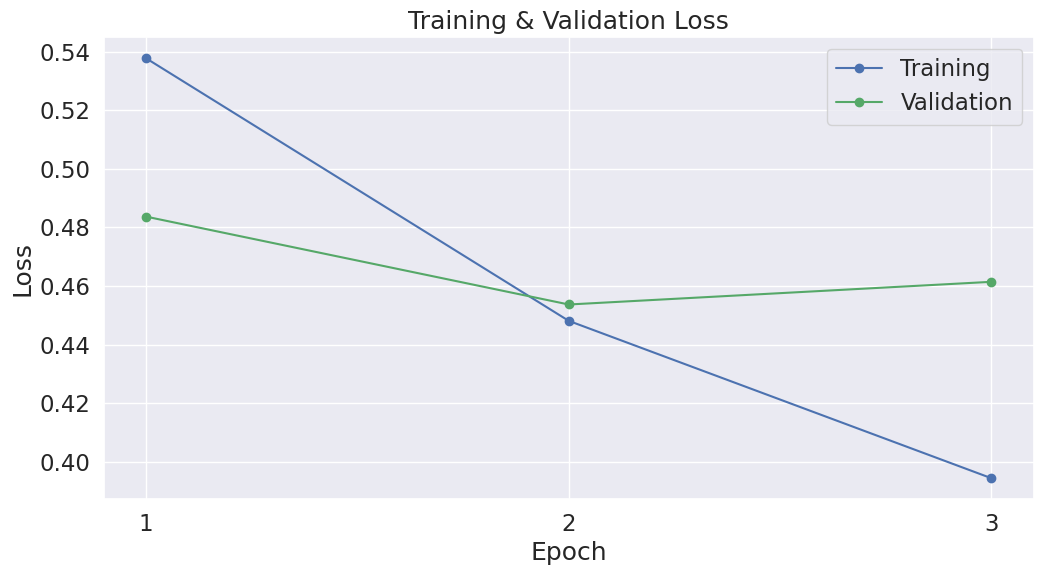

In [24]:
#@title 딥러닝 학습 간단 보기

import pandas as pd

# Display floats with two decimal places.
# pd.set_option('precision', 2)  # deprecated
pd.set_option("display.max_columns", 100)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

print(df_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
print(df_stats.to_string())

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
# plt.xticks([1, 2, 3, 4])
plt.xticks([i for i in range(1, epochs수+1)])

plt.show()

  Batch   100  of    127.    Elapsed: 0:00:21.

##### 테스트 모델을 통한 모델 정확도 #####
Accuracy: 0.78
Test took: 0:00:26

              precision    recall  f1-score   support

        bosu       0.83      0.82      0.83      5109
       jinbo       0.70      0.71      0.70      3008

    accuracy                           0.78      8117
   macro avg       0.76      0.77      0.77      8117
weighted avg       0.78      0.78      0.78      8117




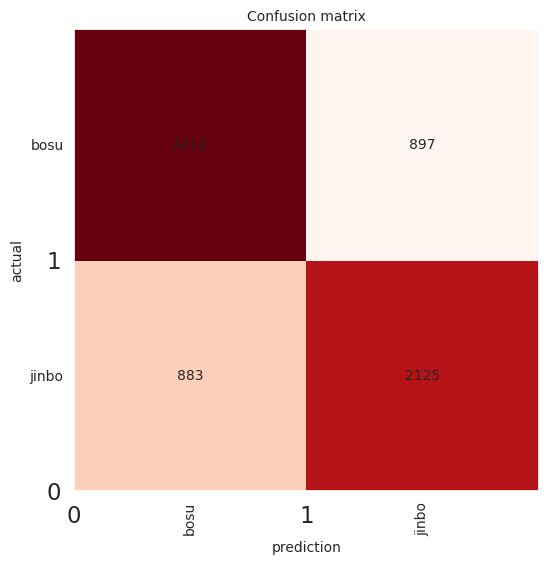

In [38]:
#@title 딥러닝 학습 평가하기

라벨링 = ['bosu','jinbo']  #@param


# import
import time

#시작 시간 설정
t0 = time.time()

# 평가모드로 변경
model.eval()


# Tracking variables
predictions , true_labels, predictionsfin = [], [], []

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_dataloader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)

    # 배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch

    # 그래디언트 계산 안함
    with torch.no_grad():
        # Forward 수행
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("##### 테스트 모델을 통한 모델 정확도 #####")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))


## 테스트 데이터를 대상으로 하는 모델 상세 평가
## precision = 정밀도 = 실제로는 False이지만 True로 라벨링 한 것에 집중
## recall = 재현율 = 실제 True인데 False 라벨링한 것에 집중
## F1 = 정밀도와 재현율의 조화평균

rounded_labels_set = []
rounded_predictions_set = []

from sklearn.metrics import classification_report

# For each input batch...
for i in range(len(true_labels)):

  rounded_labels = np.argmax(predictions[i], axis=1).flatten()
  rounded_labels_set.extend(rounded_labels)

  rounded_predictions = true_labels[i].flatten()
  rounded_predictions_set.extend(rounded_predictions)

labels = 라벨링

print("")
print(classification_report(rounded_labels_set, rounded_predictions_set, target_names=labels))
print("")


## 혼란 매트릭스 - Confusion matrix

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(rounded_labels_set, rounded_predictions_set)

def plot_confusion_matrix(
    ax, matrix, labels, title='Confusion matrix', fontsize=9):

    ax.set_xticks([x for x in range(len(labels))])
    ax.set_yticks([y for y in range(len(labels))])

    # Place labels on minor ticks
    ax.set_xticks([x + 0.5 for x in range(len(labels))], minor=True)
    ax.set_xticklabels(labels, rotation=90, fontsize=fontsize, minor=True)  # rotation must be num not str
    ax.set_yticks([y + 0.5 for y in range(len(labels))], minor=True)
    ax.set_yticklabels(labels[::-1], fontsize=fontsize, minor=True)

    # Hide major tick labels
    ax.tick_params(which='major', labelbottom='off', labelleft='off')

    # Finally, hide minor tick marks
    ax.tick_params(which='minor', width=0)

    # Plot heat map
    proportions = [1. * row / sum(row) for row in matrix]
    ax.pcolor(np.array(proportions[::-1]), cmap=plt.cm.Reds)

    # Plot counts as text
    for row in range(len(matrix)):
        for col in range(len(matrix[row])):
            confusion = matrix[::-1][row][col]
            if confusion != 0:
                ax.text(col + 0.5, row + 0.5, int(confusion),
                        fontsize=fontsize,
                        horizontalalignment='center',
                        verticalalignment='center')

    # Add finishing touches
    ax.grid(True, linestyle=':')
    ax.set_title(title, fontsize=fontsize)
    ax.set_xlabel('prediction', fontsize=fontsize)
    ax.set_ylabel('actual', fontsize=fontsize)

    plt.show()


if __name__ == '__main__':
    matrix = cm
    labels = 라벨링

    fig, ax = plt.subplots(figsize=(6, 6))

    plot_confusion_matrix(ax, matrix, labels, fontsize=10)